# <center> Предсказание победителя в Dota 2
<center> <img src="https://meduza.io/impro/YnJZAHUW6WHz_JQm1uRPkTql_qAhbfxt3oFJLGH7CJg/fill/980/0/ce/1/aHR0cHM6Ly9tZWR1/emEuaW8vaW1hZ2Uv/YXR0YWNobWVudHMv/aW1hZ2VzLzAwNy8x/NTcvNjk1L29yaWdp/bmFsL0tMVThLbUti/ZG5pSzlibDA0Wmlw/WXcuanBn.webp" width="700" height="700">

[Почитать подбробнее](https://meduza.io/feature/2021/10/19/rossiyskaya-komanda-vyigrala-chempionat-mira-po-dota-2-i-poluchila-18-millionov-dollarov-postoyte-otkuda-takie-dengi-neuzheli-igrat-v-dotu-tak-slozhno)

#### [Оригинальная статья](https://arxiv.org/pdf/2106.01782.pdf)
    
### Начало

Посмотрим на готовые признаки и сделаем первую посылку. 

1. [Описание данных](#Описание-данных)
2. [Описание признаков](#Описание-признаков)
3. [Наша первая модель](#Наша-первая-модель)
4. [Посылка](#Посылка)

### Первые шаги на пути в датасайенс

5. [Кросс-валидация](#Кросс-валидация)
6. [Что есть в json файлах?](#Что-есть-в-json-файлах?)
7. [Feature engineering](#Feature-engineering)

### Импорты

In [1]:
import os
import json
import pandas as pd
import datetime
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

%matplotlib inline

In [2]:
SEED = 10801
sns.set_style(style="whitegrid")
plt.rcParams["figure.figsize"] = 12, 8
warnings.filterwarnings("ignore")

## <left>Описание данных

Файлы:

- `sample_submission.csv`: пример файла-посылки
- `train_raw_data.jsonl`, `test_raw_data.jsonl`: "сырые" данные 
- `train_data.csv`, `test_data.csv`: признаки, созданные авторами
- `train_targets.csv`: результаты тренировочных игр

## <left>Описание признаков
    
Набор простых признаков, описывающих игроков и команды в целом

In [3]:
PATH_TO_DATA = "bi-2021-ml-competitions-dota2/"

df_train_features = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_data.csv"), 
                                    index_col="match_id_hash")
df_train_targets = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [4]:
df_train_features.shape

(31698, 245)

In [5]:
df_train_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.000000,0,0,0,0,0.00,0,0,0,0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0,0,0,0,0.00,0,0,0,0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0,0,0,0,0.00,0,0,0,0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,8.264696,0,0,3,0,0.25,0,0,3,0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,15.762911,3,1,0,1,0.50,0,0,3,0


Имеем ~32 тысячи наблюдений, каждое из которых характеризуется уникальным `match_id_hash` (захэшированное id матча), и 245 признаков. `game_time` показывает момент времени, в который получены эти данные. То есть по сути это не длительность самого матча, а например, его середина, таким образом, в итоге мы сможем получить модель, которая будет предсказывать вероятность победы каждой из команд в течение матча (хорошо подходит для букмекеров).

Нас интересует поле `radiant_win` (так называется одна из команд, вторая - dire). Остальные колоки здесь по сути получены из "будущего" и есть только для тренировочных данных, поэтому на них можно просто посмотреть).

In [6]:
df_train_targets.head()

,game_time,radiant_win,duration,time_remaining,next_roshan_team
match_id_hash,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,True,1154,496,NaN
6db558535151ea18ca70a6892197db41,21,True,1503,1482,Radiant
19c39fe2af2b547e48708ca005c6ae74,160,False,2063,1903,NaN
c96d629dc0c39f0c616d1949938a6ba6,1016,True,2147,1131,Radiant
156c88bff4e9c4668b0f53df3d870f1b,582,False,1927,1345,Dire


## <left>Наша первая модель

In [6]:
X = df_train_features.values
y = df_train_targets["radiant_win"].values.astype("int8")

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size=0.3, 
                                                      random_state=SEED)

#### Обучим случайный лес

In [9]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X_train, y_train)

CPU times: user 34.7 s, sys: 393 ms, total: 35.1 s
Wall time: 11.4 s


RandomForestClassifier(max_depth=7, n_estimators=300, n_jobs=-1,
                       random_state=10801)

#### Сделаем предсказания и оценим качество на отложенной части данных

In [10]:
y_pred = rf_model.predict_proba(X_valid)[:, 1]

In [11]:
valid_score = roc_auc_score(y_valid, y_pred)
print("ROC-AUC score на отложенной части:", valid_score)

ROC-AUC score на отложенной части: 0.7754387258058622


Посмотрим на accuracy:

In [12]:
valid_accuracy = accuracy_score(y_valid, y_pred > 0.5)
print("Accuracy score (p > 0.5) на отложенной части:", valid_accuracy)

Accuracy score (p > 0.5) на отложенной части: 0.6885383806519453


## <left>Посылка

In [13]:
df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
                                   index_col="match_id_hash")

X_test = df_test_features.values
y_test_pred = rf_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

In [14]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_17-56-49.csv


## <left>Кросс-валидация

Во многих случаях кросс-валидация оказывается лучше простого разбиения на test и train. Воспользуемся `ShuffleSplit` чтобы создать 5 70%/30% наборов данных.

In [15]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [16]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
cv_scores_rf = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc")

CPU times: user 9.06 s, sys: 1.04 s, total: 10.1 s
Wall time: 1min 19s


In [17]:
cv_scores_rf

array([0.77543873, 0.77343884, 0.76649967, 0.7722681 , 0.77246001])

In [18]:
print(f"Среднее значение ROC-AUC на кросс-валидации: {cv_scores_rf.mean()}")

Среднее значение ROC-AUC на кросс-валидации: 0.7720210676055513


## <left>Что есть в json файлах?

Описание сырых данных можно найти в `train_matches.jsonl` и `test_matches.jsonl`. Каждый файл содержит одну запись для каждого матча в [JSON](https://en.wikipedia.org/wiki/JSON) формате. Его легко превратить в питоновский объект при помощи метода `json.loads`.

In [19]:
with open(os.path.join(PATH_TO_DATA, "train_raw_data.jsonl")) as fin:
    # прочтем 419 строку
    for i in range(419):
        line = fin.readline()
    
    # переведем JSON в питоновский словарь 
    match = json.loads(line)

In [21]:
player = match["players"][9]
player["kills"], player["deaths"], player["assists"]

(0, 5, 5)

KDA - может быть неплохим признаком, этот показатель считается как:
    
<center>$KDA = \frac{K + A}{D}$

Информация о количестве использованных способностей:

In [22]:
player["ability_uses"]

{'treant_living_armor': 52, 'treant_leech_seed': 5, 'treant_overgrowth': 5}

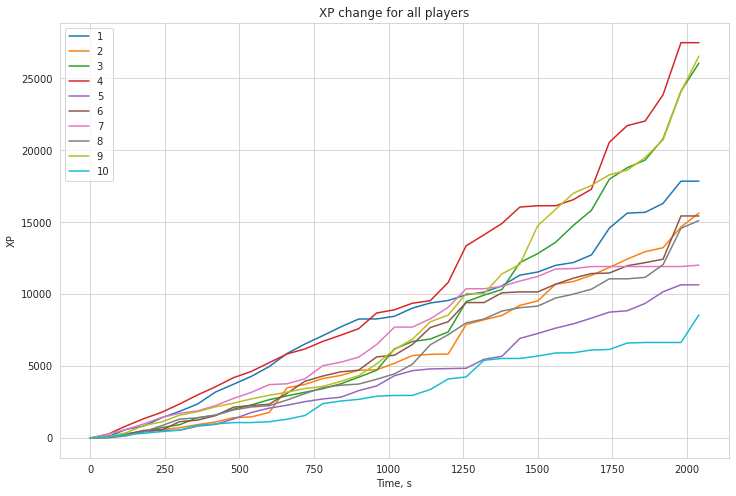

In [23]:
for i, player in enumerate(match["players"]):
    plt.plot(player["times"], player["xp_t"], label=str(i+1))

plt.legend()
plt.xlabel("Time, s")
plt.ylabel("XP")
plt.title("XP change for all players");

#### Сделаем чтение файла с сырыми данными и добавление новых признаков удобным

В этот раз для чтение `json` файлов лучше использовать библиотеку `ujson`, иначе все будет слишком долго :(

In [7]:
try:
    import ujson as json
except ModuleNotFoundError:
    import json
    print ("Подумайте об установке ujson, чтобы работать с JSON объектами быстрее")
    
try:
    from tqdm.notebook import tqdm
except ModuleNotFoundError:
    tqdm_notebook = lambda x: x
    print ("Подумайте об установке tqdm, чтобы следить за прогрессом")

    
def read_matches(matches_file, total_matches=31698, n_matches_to_read=None):
    """
    Аргуент
    -------
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Возвращает записи о каждом матче
    """
    
    if n_matches_to_read is None:
        n_matches_to_read = total_matches
        
    c = 0
    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            if c >= n_matches_to_read:
                break
            else:
                c += 1
                yield json.loads(line)

Подумайте об установке ujson, чтобы работать с JSON объектами быстрее


#### Чтение данных в цикле

Чтение всех данных занимает 1-2 минуты, поэтому для начала можно попробовать следующее:

1. Читать 10-50 игр
2. Написать код для работы с этими JSON объектами
3. Убедиться, что все работает
4. Запустить код на всем датасете
5. Сохранить результат в `pickle` файл, чтобы в следующий раз не переделывать все заново

## <left>Feature engineering

Напишем функцию, которая поможет нам легче добавлять новые признаки.

In [8]:
def add_new_features(df_features, matches_file):
    """
    Аргуенты
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file):
        match_id_hash = match['match_id_hash']

        # Посчитаем количество разрушенных вышек обеими командами
        radiant_tower_kills = 0
        dire_tower_kills = 0
        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_TOWER_KILL":
                if objective["team"] == 2:
                    radiant_tower_kills += 1
                if objective["team"] == 3:
                    dire_tower_kills += 1

        df_features.loc[match_id_hash, "radiant_tower_kills"] = radiant_tower_kills
        df_features.loc[match_id_hash, "dire_tower_kills"] = dire_tower_kills
        df_features.loc[match_id_hash, "diff_tower_kills"] = radiant_tower_kills - dire_tower_kills
        
        # ... (/¯◡ ‿ ◡)/¯☆*:・ﾟ добавляем новые признаки ...

In [9]:
# в случае ошибки "Widget Javascript not detected.  It may not be installed or enabled properly."
#     в нижестоящем блоке кода

!pip3 install ipywidgets==7.0.0

In [10]:
# Скопируем таблицу с признаками
df_train_features_extended = df_train_features.copy()

# Добавим новые
add_new_features(df_train_features_extended, 
                 os.path.join(PATH_TO_DATA, 
                              "train_raw_data.jsonl"))

A Jupyter Widget

In [11]:
df_train_features_extended.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed,radiant_tower_kills,dire_tower_kills,diff_tower_kills
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0,0,0.00,0,0,0,0,2.0,0.0,2.0
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0,0,0.00,0,0,0,0,0.0,0.0,0.0
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3,0,0.25,0,0,3,0,0.0,0.0,0.0
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0,1,0.50,0,0,3,0,0.0,1.0,-1.0


In [30]:
%%time
cv_scores_base = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
cv_scores_extended = cross_val_score(rf_model, df_train_features_extended.values, y, 
                                     cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 110 ms, sys: 240 ms, total: 349 ms
Wall time: 1min 58s


In [31]:
print(f"ROC-AUC на кросс-валидации для базовых признаков: {cv_scores_base.mean()}")
print(f"ROC-AUC на кросс-валидации для новых признаков: {cv_scores_extended.mean()}")

ROC-AUC на кросс-валидации для базовых признаков: 0.7720210676055513
ROC-AUC на кросс-валидации для новых признаков: 0.778796825263235


Видно, что случайный лес стал работать немного лучше при добавлении новых признаков. A еще нужно, наверное, как-то по-умному закодировать категориальные признаки.

Дальше дело за малым. Добавляйте новые признаки, пробуйте другие методы, которые мы изучили, а также что-то интересное, что мы не прошли. Удачи!

<br><br><br><br><br><br><br><br><br>

<hr>

<div align='center' style="background: lightgreen"> 
    
## My own work
    
</div>

<hr>

Отталкиваясь от сделанного в baseline накидаем своего.

$~$

### 1. Признаки

Общие признаки для игры:

In [43]:
df_train_features.columns[:5]

Index(['game_time', 'game_mode', 'lobby_type', 'objectives_len', 'chat_len'], dtype='object')

Для каждого игрока имеются следующие признаки:

In [13]:
# герой, килы, смерти, опыт, число станов, взятие ФБ и т.п.

[feature for feature in df_train_features.columns if 'r1_' in feature]

['r1_hero_id',
 'r1_kills',
 'r1_deaths',
 'r1_assists',
 'r1_denies',
 'r1_gold',
 'r1_lh',
 'r1_xp',
 'r1_health',
 'r1_max_health',
 'r1_max_mana',
 'r1_level',
 'r1_x',
 'r1_y',
 'r1_stuns',
 'r1_creeps_stacked',
 'r1_camps_stacked',
 'r1_rune_pickups',
 'r1_firstblood_claimed',
 'r1_teamfight_participation',
 'r1_towers_killed',
 'r1_roshans_killed',
 'r1_obs_placed',
 'r1_sen_placed']

**P.S.**: игроки 0-4 в списке это команда radiant, а игроки 5-9 это команда dire

Функция для добавления моих признаков:

In [51]:
def my_own_add_new_features(df_features, matches_file, n_matches_to_read=31698):
    """
    Аргументы
    -------
    df_features: таблица с данными
    matches_file: JSON файл с сырыми данными
    
    Результат
    ---------
    Добавляет новые признаки в таблицу
    """
    
    for match in read_matches(matches_file, n_matches_to_read=n_matches_to_read):
        # сразу запоминаем хэш
        match_id_hash = match['match_id_hash']


        # ==============================================================================================
        # ======================================  Признак 1: KDA  ======================================
        # ==============================================================================================

        # порядок игроков в match['players']:
        # ['r1', 'r2', 'r3', 'r4', 'r5', 'd1', 'd2', 'd3', 'd4', 'd5']
        order = ['r'+str(i) for i in range(1,6)] + ['d'+str(i) for i in range(1,6)]

        for i, player in enumerate(match['players']):
            k = player['kills']
            a = player['assists']
            d = player['deaths']
            kda = (k + a) / max(1, d)

            df_features.loc[match_id_hash, order[i]+'_kda'] = kda


        # ==============================================================================================
        # =====================================  Признак 2: pings  =====================================
        # ==============================================================================================

        # Чем активнее команда пингует (если конечно не троллит), тем лучше у них коммуникация
        # смотрим на среднее число пингов на команду

        r_pings = [sum(match['players'][i]['pings'].values()) for i in range(5)]
        r_pings_avg = sum(r_pings) / 5
        d_pings = [sum(match['players'][i]['pings'].values()) for i in range(5,10)]
        d_pings_avg = sum(d_pings) / 5

        df_features.loc[match_id_hash, 'radiant_avg_pings'] = r_pings_avg
        df_features.loc[match_id_hash, 'dire_avg_pings'] = d_pings_avg


        # ==============================================================================================
        # ======================================  Признак 3: DMG  ======================================
        # ==============================================================================================

        # Наверное должна быть некая тенденция -- чем больше вносишь дамага, тем чаще они умирают))
        # Смотрим на дамаг нанесённый по героям вражеской команды (list comprehesion выглядит страшно, сорян)

        r_dmg = [sum([d[1] for d in match['players'][i]['damage'].items() if 'npc_dota_hero' in d[0]]) for i in range(5)]
        r_dmg_avg = sum(r_dmg) / 5
        d_dmg = [sum([d[1] for d in match['players'][i]['damage'].items() if 'npc_dota_hero' in d[0]]) for i in range(5,10)]
        d_dmg_avg = sum(d_dmg) / 5
        
        df_features.loc[match_id_hash, 'radiant_avg_dmg'] = r_dmg_avg
        df_features.loc[match_id_hash, 'dire_avg_dmg'] = d_dmg_avg


        # ==============================================================================================
        # ===================================+===  Признак 4: FB  ======================================
        # ==============================================================================================

        # Проще смотреть не на персонажа, который получил ФБ, а на его команду
        # Получаешь ФБ --> больше шанс выиграть

        for objective in match["objectives"]:
            if objective["type"] == "CHAT_MESSAGE_FIRSTBLOOD":
                if objective["slot"] <= 4:
                    radiant_fb = 1
                else:
                    radiant_fb = 0
                    
        df_features.loc[match_id_hash, 'radiant_fb'] = radiant_fb
        
        
        # ==============================================================================================
        # ==================================  Признак 5: tp_scrolls  ===================================
        # ==============================================================================================

        # Можно предположить что команда с большим числом tp_scrolls будет активнее действовать по карте
        
        r_scrolls = [match['players'][i]['purchase'].get('tpscroll', 0) for i in range(5)]
        r_scrolls_avg = sum(r_scrolls) / 5
        d_scrolls = [match['players'][i]['purchase'].get('tpscroll', 0) for i in range(5,10)]
        d_scrolls_avg = sum(d_scrolls) / 5
        
        df_features.loc[match_id_hash, 'radiant_avg_tp_scrolls'] = r_scrolls_avg
        df_features.loc[match_id_hash, 'dire_avg_tp_scrolls'] = d_scrolls_avg

In [52]:
# Копия датасета

my_features = df_train_features_extended.copy()


# Добавим новые признаки
my_own_add_new_features(my_features, 
                        os.path.join(PATH_TO_DATA, "train_raw_data.jsonl"))

A Jupyter Widget

In [53]:
my_features.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,d3_kda,d4_kda,d5_kda,radiant_avg_pings,dire_avg_pings,radiant_avg_dmg,dire_avg_dmg,radiant_fb,radiant_avg_tp_scrolls,dire_avg_tp_scrolls
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,0.666667,0.666667,0.0,9.4,8.0,3492.6,2612.6,0.0,2.8,3.2
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0.000000,0.0,0.0,0.0,14.0,13.6,0.0,1.0,1.0
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0.000000,0.0,0.8,0.6,454.0,244.0,0.0,0.8,1.2
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,3.500000,2.000000,3.0,12.6,3.0,4774.4,4544.4,1.0,4.0,4.2
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,5.000000,2.000000,2.5,1.2,8.8,1966.0,4568.8,0.0,2.4,1.8


**Ещё мысли:** можно добавить что-то про пользование курьером, но я не нашёл такого :(

$~$

Вообще говоря, смотреть на золото или число убийств конкретной команды смысла мало (по крайней мере мне так кажется). Гораздо логичнее смотреть на разницу в золоте/опыте/КДА и прочем между командами.

Поэтому **"усредним" датасет и посчитаем относительные значения**.

In [194]:
# запомним, какие вообще признаки у нас присущи игрокам
features_for_every_player = ['kda',
                             'denies',
                             'gold',
                             'lh',
                             'xp',
                             'max_mana',
                             'max_health',
                             'level',
                             'x',
                             'y', 
                             'stuns', 
                             'creeps_stacked', 
                             'camps_stacked', 
                             'rune_pickups', 
                             'teamfight_participation', 
                             'roshans_killed', 
                             'obs_placed', 
                             'sen_placed']

In [195]:
for i in tqdm(range(len(my_features)), total=len(my_features)):
    # для каждой игры...
    match = my_features.iloc[i,:]
    match_id_hash = match.name
    for j, feature in enumerate(features_for_every_player):
        # для каждого признака...
        radiant_f = [my_features.loc[match_id_hash, r + '_' + feature] for r in ['r1', 'r2', 'r3', 'r4', 'r5']]
        dire_f = [my_features.loc[match_id_hash, d + '_' + feature] for d in ['d1', 'd2', 'd3', 'd4', 'd5']]
        
        radiant_f_avg = sum(radiant_f) / 5
        dire_f_avg = sum(dire_f) / 5
        
        # во сколько раз признак у команд различается
        f_relative = dire_f_avg / radiant_f_avg if radiant_f_avg != 0 else dire_f_avg / 1
        f_name = features_for_every_player[j] + '_relative'
        
        my_features.loc[match_id_hash, f_name] = f_relative
        
my_features.head()

A Jupyter Widget

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,x_relative,y_relative,stuns_relative,creeps_stacked_relative,camps_stacked_relative,rune_pickups_relative,teamfight_participation_relative,roshans_killed_relative,obs_placed_relative,sen_placed_relative
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,1.094463,1.064140,0.083987,1.500000,2.0,1.076923,0.800000,0.0,1.250000,0.666667
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,1.372414,1.255973,0.000000,0.000000,0.0,0.333333,0.000000,0.0,0.000000,0.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,1.229091,1.080925,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,1.006557,1.264085,0.767407,0.000000,0.0,0.375000,0.952381,0.0,1.166667,0.500000
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,1.185430,1.117871,8.630047,0.428571,0.4,1.333333,0.923077,0.0,2.000000,0.200000


$~$

Отдельно ещё посчитаем разницу для наших фичей:

In [201]:
some_more_avg_features = ['avg_pings', 'avg_dmg', 'avg_tp_scrolls']

for i in tqdm(range(len(my_features)), total=len(my_features)):
    # для каждой игры...
    match = my_features.iloc[i,:]
    match_id_hash = match.name
    for j, feature in enumerate(some_more_avg_features):
        # для каждого признака...
        radiant_f = my_features.loc[match_id_hash, 'radiant_' + feature]
        dire_f = my_features.loc[match_id_hash, 'dire_' + feature]
        
        # во сколько раз признак у команд различается
        f_relative = dire_f / radiant_f if radiant_f != 0 else dire_f / 1
        f_name = some_more_avg_features[j] + '_relative'
        
        my_features.loc[match_id_hash, f_name] = f_relative
        
my_features.head()

A Jupyter Widget

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,...,creeps_stacked_relative,camps_stacked_relative,rune_pickups_relative,teamfight_participation_relative,roshans_killed_relative,obs_placed_relative,sen_placed_relative,avg_pings_relative,avg_dmg_relative,avg_tp_scrolls_relative
match_id_hash,,,,,,,,,,,,,,,,,,,,,
b9c57c450ce74a2af79c9ce96fac144d,658,4,0,3,10,15,7,2,0,7,...,1.500000,2.0,1.076923,0.800000,0.0,1.250000,0.666667,0.851064,0.748039,1.142857
6db558535151ea18ca70a6892197db41,21,23,0,0,0,101,0,0,0,0,...,0.000000,0.0,0.333333,0.000000,0.0,0.000000,0.000000,0.000000,0.971429,1.000000
19c39fe2af2b547e48708ca005c6ae74,160,22,7,0,0,57,0,0,0,1,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.750000,0.537445,1.500000
c96d629dc0c39f0c616d1949938a6ba6,1016,22,0,1,0,119,0,3,3,5,...,0.000000,0.0,0.375000,0.952381,0.0,1.166667,0.500000,0.238095,0.951826,1.050000
156c88bff4e9c4668b0f53df3d870f1b,582,22,7,2,2,12,3,1,2,9,...,0.428571,0.4,1.333333,0.923077,0.0,2.000000,0.200000,7.333333,2.323906,0.750000


Есть ещё мысль **убрать короткие игры**. Потому что если игра идёт всего 25 секунд, то предсказать исход сложно, и наверное модель научится какой-нибудь фигне:

In [217]:
short_games = my_features.loc[my_features['game_time']<120, :].index.to_list()
short_games[:5]

['6db558535151ea18ca70a6892197db41',
 'a3c3892648b873bb869dd81ca0f62286',
 '73669c2af74776b891fb94a1d1099d25',
 '3c666e1759bfab4467d11010983fb13e',
 'ba1e963ea091e6af635dedd4ad2e9bbd']

In [219]:
my_features_only_long = my_features.drop(short_games)

my_features.shape, my_features_only_long.shape

((31698, 286), (29878, 286))

In [220]:
df_train_targets_only_long = df_train_targets.drop(short_games)

df_train_targets.shape, df_train_targets_only_long.shape

((31698, 5), (29878, 5))

**(Это действительно улучшает скор)**

$~$

### 2. Модели

#### Сначала попробуем провериться на имеющейся baseline модели:

In [221]:
# X = my_features.values
# y = df_train_targets["radiant_win"].values.astype("int8")  # прописано выше, просто чтобы не забывать

X = my_features_only_long.values
y = df_train_targets_only_long["radiant_win"].values.astype("int8")

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=SEED)

In [223]:
%%time
rf_model = RandomForestClassifier(n_estimators=300, max_depth=7, n_jobs=-1, random_state=SEED)
rf_model.fit(X, y)
cv_scores_my = cross_val_score(rf_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 46.5 s, sys: 216 ms, total: 46.8 s
Wall time: 1min 9s


In [225]:
print(f"ROC-AUC: {cv_scores_my.mean()}")
print("ROC-AUC на кросс-валидации для новых признаков: 0.778796")

ROC-AUC: 0.828470737487214
ROC-AUC на кросс-валидации для новых признаков: 0.778796


Ух тыыы, $+0.05$ пунктов относительно baseline_extended только за счёт фичей! )

$~$

#### Теперь возьмём что-то посложнее. Например, catboost:

In [226]:
import catboost

In [227]:
CAT_model = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)

In [228]:
%%time
cv_scores_catboost = cross_val_score(CAT_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 54.6 ms, sys: 95.9 ms, total: 151 ms
Wall time: 3min 57s


In [229]:
print(f"ROC-AUC на кросс-валидации: {cv_scores_catboost.mean()}")

ROC-AUC на кросс-валидации: 0.8310676819220468


$0.83$ на стандартных настройках. Весьма недурно.

$~$

Попробуем подобрать гиперпараметры для catboost'а:

In [230]:
# Reporting util for different optimizers
def report_perf(optimizer, X, y, title, callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    if callbacks:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           +u"\u00B1"+" %.3f") % (time() - start, 
                                  len(optimizer.cv_results_['params']),
                                  best_score,
                                  best_score_std))    
#     print('Best parameters:')
#     pprint.pprint(best_params)
#     print()
    return best_params

In [231]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

from sklearn.model_selection import StratifiedKFold

In [232]:
roc_auc = make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

In [233]:
clf = catboost.CatBoostClassifier(thread_count=2,
                         loss_function='Logloss',
                        
                         od_type = 'Iter',
                         verbose= False
                        )

In [234]:
!pip3 install scikit-optimize

In [235]:
from skopt.space import Real, Categorical, Integer
from time import time

In [236]:
# Какие гиперпараметры перебираем

search_spaces = {'iterations': Integer(10, 1000),
                 'depth': Integer(1, 8),
                 'learning_rate': Real(0.01, 1.0, 'log-uniform'),
                 'random_strength': Real(1e-9, 10, 'log-uniform'),
                 'bagging_temperature': Real(0.0, 1.0),
                 'border_count': Integer(1, 255),
                 'l2_leaf_reg': Integer(2, 30),
                 'scale_pos_weight':Real(0.01, 1.0, 'uniform')}

In [237]:
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, VerboseCallback, DeltaXStopper

In [238]:
# BayesSearchCV

opt = BayesSearchCV(clf,
                    search_spaces,
                    scoring=roc_auc,
                    cv=skf,
                    n_iter=100,
                    n_jobs=1,
                    return_train_score=False,
                    refit=True,
                    optimizer_kwargs={'base_estimator': 'GP'},
                    random_state=42)

In [239]:
best_params = report_perf(opt, X, y,'CatBoost', 
                          callbacks=[VerboseCallback(100), 
                                     DeadlineStopper(60*10)])

Iteration No: 1 started. Searching for the next optimal point.
Iteration No: 1 ended. Search finished for the next optimal point.
Time taken: 175.3395
Function value obtained: -0.8268
Current minimum: -0.8268
Iteration No: 2 started. Searching for the next optimal point.
Iteration No: 2 ended. Search finished for the next optimal point.
Time taken: 102.3825
Function value obtained: -0.8281
Current minimum: -0.8281
Iteration No: 3 started. Searching for the next optimal point.
Iteration No: 3 ended. Search finished for the next optimal point.
Time taken: 54.0439
Function value obtained: -0.8279
Current minimum: -0.8281
Iteration No: 4 started. Searching for the next optimal point.
Iteration No: 4 ended. Search finished for the next optimal point.
Time taken: 111.1585
Function value obtained: -0.8289
Current minimum: -0.8289
Iteration No: 5 started. Searching for the next optimal point.
CatBoost took 464.62 seconds,  candidates checked: 4, best CV score: 0.829 ± 0.003


In [241]:
best_params

OrderedDict([('bagging_temperature', 0.8123959883573634),
             ('border_count', 45),
             ('depth', 5),
             ('iterations', 805),
             ('l2_leaf_reg', 17),
             ('learning_rate', 0.01552065618292981),
             ('random_strength', 0.0361414296804267),
             ('scale_pos_weight', 0.8739040497768427)])

In [242]:
best_params['iterations'] = 1000

In [243]:
%%time
tuned_model = catboost.CatBoostClassifier(**best_params, od_type='Iter', verbose=0, random_seed=SEED)
cv_scores_catboost = cross_val_score(tuned_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 58.4 ms, sys: 120 ms, total: 178 ms
Wall time: 2min 11s


In [244]:
print(f"ROC-AUC на CATBOOST с подобранными гиперпараметрами: {cv_scores_catboost.mean()}")

ROC-AUC на CATBOOST с подобранными гиперпараметрами: 0.8316041885528305


**Подбор параметров прибавил лишь $+0.0006$ пунктов :(**

$~$

#### XGBoost:

In [245]:
import xgboost

In [246]:
XGB_model = xgboost.XGBClassifier(random_state=SEED)

In [247]:
%%time
cv_scores_xgboost = cross_val_score(XGB_model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 73.4 ms, sys: 80 ms, total: 153 ms
Wall time: 3min 21s


In [248]:
print(f"ROC-AUC на кросс-валидации: {cv_scores_xgboost.mean()}")

ROC-AUC на кросс-валидации: 0.8135090572097796


In [19]:
grid_param_xgb = {'booster':['gbtree'],
                  'objective':['binary:logistic'],
                  'nthread':[-1],
                  'learning_rate': [0.1, 0.05],
                  'max_depth': [3,6,7],
                  'min_child_weight': [1,5,11],
                  'silent': [0],
                  'subsample': [0.8, 1],
                  'colsample_bytree': [0.5, 0.8],
                  'n_estimators': [100],
#                   'n_estimators': [5,50,100,300,500,800,1000],
                  'seed': [SEED]
                 }

In [20]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_search_xgb = GridSearchCV(estimator=XGB_model,
                               error_score = 'raise',
                               param_grid=grid_param_xgb,
                               scoring='accuracy',
                               cv=5,
                               n_jobs=-1,
                               verbose=0)

grid_search_xgb.fit(X, y)

In [25]:
print(grid_search_xgb.best_params_)
print(grid_search_xgb.best_score_)
print(grid_search_xgb.best_estimator_)

{'booster': 'gbtree', 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 11, 'n_estimators': 100, 'nthread': -1, 'objective': 'binary:logistic', 'seed': 10801, 'silent': 0, 'subsample': 0.8}
0.7123794068365529
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=11, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, nthread=-1, num_parallel_tree=1,
              predictor='auto', random_state=10801, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=10801, silent=0, subsample=0.8,
              tree_method='exact', validate_parameters=1, ...)


In [252]:
%%time
tuned_XGBoost = xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                                      colsample_bynode=1, colsample_bytree=0.5,
                                      enable_categorical=False, gamma=0, gpu_id=-1,
                                      importance_type=None, interaction_constraints='',
                                      learning_rate=0.1, max_delta_step=0, max_depth=6,
                                      min_child_weight=11, monotone_constraints='()',
                                      n_estimators=100, n_jobs=4, nthread=-1, num_parallel_tree=1,
                                      predictor='auto', random_state=SEED, reg_alpha=0, reg_lambda=1,
                                      scale_pos_weight=1, seed=SEED, silent=0, subsample=0.8,
                                      tree_method='exact', validate_parameters=1)

cv_scores_XGBoost = cross_val_score(tuned_XGBoost, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)

CPU times: user 38.6 ms, sys: 112 ms, total: 151 ms
Wall time: 2min 8s


In [253]:
print(f"ROC-AUC на кросс-валидации: {cv_scores_XGBoost.mean()}")

ROC-AUC на кросс-валидации: 0.8290729682694792


**XGBoost с подобранными гиперпараметрами дал 0.82907**

$~$

#### Ну и ещё немного:

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', max_iter=10000)
cv_scores_lr = cross_val_score(lr, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации: {cv_scores_lr.mean()}")

$~$

#### Ansamble:

# ЧИТЫ

In [163]:
PATH_TO_DATA = "data2/"

df_train_features2 = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                             "train_features.csv"), 
                                    index_col="match_id_hash")
df_train_targets2 = pd.read_csv(os.path.join(PATH_TO_DATA, 
                                            "train_targets.csv"), 
                                   index_col="match_id_hash")

In [184]:
# Копия датасета

my_features2 = df_train_features2.copy()


# Добавим новые признаки
my_own_add_new_features(my_features2, 
                        os.path.join(PATH_TO_DATA, "train_matches.jsonl"),
                        n_matches_to_read=39675)

A Jupyter Widget

In [185]:
X2 = my_features2.values
y2 = df_train_targets2["radiant_win"].values.astype("int8")  # прописано выше, просто чтобы не забывать

In [171]:
%%time
cv_scores_catboost2 = cross_val_score(CAT_model, X2, y2, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"ROC-AUC на кросс-валидации: {cv_scores_catboost2.mean()}")

ROC-AUC на кросс-валидации для новых признаков: 0.8025379420587451
CPU times: user 88.2 ms, sys: 124 ms, total: 213 ms
Wall time: 4min 29s


False

In [253]:
y_test_pred = list(map(int, [df_train_targets2.loc[i, 'radiant_win'] for i in list(df_test_features.index)]))

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_22-28-31.csv


In [186]:
X2.shape

(39675, 260)

In [187]:
X.shape

(31698, 263)

In [194]:
# df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
#                                    index_col="match_id_hash")
df_test_features2 = df_test_features.copy()
my_own_add_new_features(df_test_features2, 
                        os.path.join("bi-2021-ml-competitions-dota2/", "test_raw_data.jsonl"))

X_test = df_test_features2.values
CAT_model.fit(X2, y2)
y_test_pred = CAT_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

A Jupyter Widget

In [195]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_21-22-32.csv


In [199]:
# без читов


# df_test_features = pd.read_csv(os.path.join(PATH_TO_DATA, "test_data.csv"), 
#                                    index_col="match_id_hash")
df_test_features3 = df_test_features.copy()
add_new_features(df_test_features3, 
                 os.path.join("bi-2021-ml-competitions-dota2/", "test_raw_data.jsonl"))
my_own_add_new_features(df_test_features3, 
                        os.path.join("bi-2021-ml-competitions-dota2/", "test_raw_data.jsonl"))

X_test = df_test_features3.values
CAT_model.fit(X, y)
y_test_pred = CAT_model.predict_proba(X_test)[:, 1]

df_submission = pd.DataFrame({"radiant_win_prob": y_test_pred}, 
                                 index=df_test_features.index)

A Jupyter Widget

A Jupyter Widget

In [200]:
submission_filename = "submission_{}.csv".format(
    datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S"))
df_submission.to_csv(submission_filename)
print("Файл посылки сохранен, как: {}".format(submission_filename))

Файл посылки сохранен, как: submission_2022-03-26_21-31-21.csv
